# Overview of SwissLandStats

Let us first download and unzip the data (note that the `make` command in the cell below will probably not work in Windows - in such case you might [click here](https://www.bfs.admin.ch/bfsstatic/dam/assets/6646411/master) to download the data manually)

In [1]:
!make download_data

make: Nothing to be done for 'download_data'.


In [2]:
import swisslandstats as sls

## IO and plotting

Now we can read the land statistics file from the Swiss Federal Statistical Office (SFSO) e.g., the Standard nomenclature NOAS04. It might take a while since there are over 2.7 million rows.

In [3]:
ldf = sls.read_csv('data/AREA_NOAS04_17_181029.csv')

Then `ldf` will be a `LandDataFrame` object, which extends a pandas `DataFrame` with some methods aimed to process geographic raster data.

In [4]:
ldf.head()

,E,N,X,Y,GMDE,FJ85,FJ97,FJ09,FJ18,AS85R_17,AS97R_17,AS09R_17,AS18_17,AS85R_4,AS97R_4,AS09R_4,AS18_4
RELI,,,,,,,,,,,,,,,,,
48551097,2485500,1109700,485500,109700,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551098,2485500,1109800,485500,109800,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551099,2485500,1109900,485500,109900,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551100,2485500,1110000,485500,110000,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3
48551101,2485500,1110100,485500,110100,6611,1980,1992,2004,2012,10,10,10,10,3,3,3,3


Each row corresponds to a pixel, where `E`, `N` denote the coordinates of its centroid (in the [LV95 coordinate system](https://www.swisstopo.admin.ch/en/knowledge-facts/surveying-geodesy/reference-frames/local/lv95.html), or alternatively `X` and `Y` in [LV03](https://www.swisstopo.admin.ch/en/knowledge-facts/surveying-geodesy/reference-frames/local/lv03.html)).

The `FJ85`, `FJ97`, `FJ09` and `FJ18` denote the exact years when the observations for each of the four survey periods were taken. See [the datset description (link in French)](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie.html) for more information. The columns of the form *AS{survey_period}_{num_classes}* denote the land use/land cover class at its respective survey period. The free tier includes classifications for 17 and 4 land use/land cover classes.

Let us first plot a land use/land cover column, e.g., the land use/land cover [classified into the 4 main classes](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie/nomenclature-standard.html) for the 2013/18 survey. We can use any colormap that works with matplotlib. In this example, we will use one that is well suited for the 4 main classes classification, which is included within the swisslandastats library:

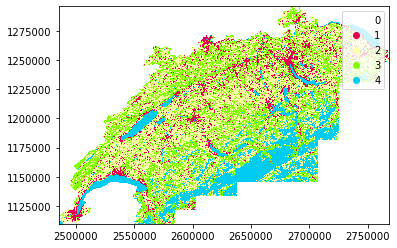

In [5]:
ldf.plot('AS18_4', cmap=sls.noas04_4_cmap, legend=True)

See the documentation for `LandDataFrame.plot` for more details.

On the other hand, we can use the `to_ndarray` method to transform any column to a numpy array:

In [6]:
ldf.to_ndarray('AS18_4')

array([[3, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 2, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 2, 2, ..., 0, 0, 0]], dtype=uint8)

Or also export any column to a GeoTiff file by means of the `to_geotiff` method, where the first argument corresponds to the output file path, and the second to the data column:

In [7]:
ldf.to_geotiff('as18_4.tif', 'AS18_4')

## Basic transformations

We can operate over a `LandDataFrame` as we would do with any pandas `DataFrame`. For example, we can create a new column that represents the pixels that have been transformed from non-urban to urban during the 2004/09-2013/18 period:

In [8]:
ldf['urban_09-18'] = (ldf['AS18_4'] == 1) & (ldf['AS09R_4'] != 1)

Let us plot the new column:

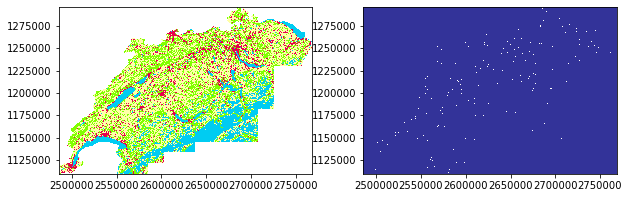

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ldf.plot('AS09R_4', cmap=sls.noas04_4_cmap, ax=axes[0])
ldf.plot('urban_09-18', ax=axes[1])

We might also subset our region by selecting a set of rows of interest:

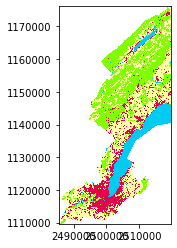

In [10]:
ldf.iloc[:100000].plot('AS09R_4', cmap=sls.noas04_4_cmap)

## Geometric transformations

Selecting pixel rows is not the most natural way to extract geographic regions. Instead, we can clip a `LandDataFrame` instance to the extents of a given geometry. Note that .

Let us first use osmnx in order to obtain the bounds of a region of interest, e.g., the municipality of Lausanne:

In [11]:
import osmnx as ox

geometry = ox.gdf_from_place('Lausanne, Vaud')['geometry'].iloc[0]

Now we can use the `clip_by_geometry` method in order to clip the `LandDataFrame` to the extents of such geometry. Just note that the [coordinate reference system](https://en.wikipedia.org/wiki/Spatial_reference_system) of the geometry must be provided, otherwise, the one from the swisslandstats' `settings` module will be taken (i.e., [EPSG:2056](https://spatialreference.org/ref/epsg/2056) by default). Since the geometry of this example has been extracted from the OpenStreetMap, it will be in [EPSG:4326](https://spatialreference.org/ref/epsg/4326).

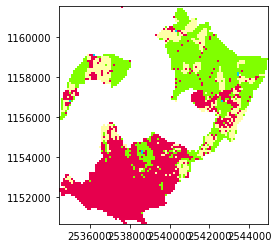

In [12]:
subset_ldf = ldf.clip_by_geometry(geometry, geometry_crs={'init': 'epsg:4326'})
subset_ldf.plot('AS09R_4', cmap=sls.noas04_4_cmap)

Also note that clipping `LandDataFrame` instances by geometries might still be [due to the current implementation of geopandas](https://jorisvandenbossche.github.io/blog/2017/09/19/geopandas-cython/). Hopefully, [this will be resolved soon](https://github.com/geopandas/geopandas/issues/473) and we can expect significant speed-ups in such geometric operations.

In any case, the `clip_by_nominatim` method provides a shortcut for what has been done above:

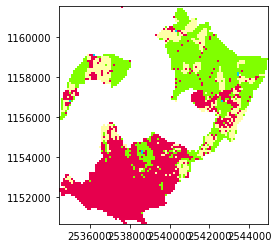

In [13]:
same_subset_ldf = ldf.clip_by_nominatim('Lausanne, Vaud')
same_subset_ldf.plot('AS09R_4', cmap=sls.noas04_4_cmap)